In [1]:
import itertools
import copy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv("Full data MP Mentions.csv", engine="python")

In [3]:

#remove any tweets that have less than 26 favorites
df = df.set_index("favorites")
for i in range(26):
    df = df.drop(i, axis=0)
df.reset_index
df = df.sort_values(by='date',ascending=True)
df=df.reset_index(drop=True)
df

,Unnamed: 0,user_id,tweet_id,retweet,tweet,date
0,85350,2.942830e+08,914278821997813761,16,"Though thanks to Toryscum, thousands of disabl...",2017-10-01 01:00:32
1,432565,2.481868e+08,914314202810068993,23,Good grief: Deadwood thinks we're negotiating ...,2017-10-01 03:21:07
2,1676614,2.914303e+09,914341572535312384,127,This makes me so sad. Anorexia silently kills ...,2017-10-01 05:09:53
3,1898713,1.880636e+08,914360183530409985,20,Why is UK only EU MS that supposedly has probl...,2017-10-01 06:23:50
4,1898712,1.880636e+08,914360928900145152,8,UK prob is no register of inhabitants so no ab...,2017-10-01 06:26:48
...,...,...,...,...,...,...
48141,1846799,7.108919e+08,936018274575437824,0,I'm an @LordBuckethead voter and I agree too.,2017-11-29 23:45:21
48142,194628,3.674246e+09,936019265920143360,39,Everybody�s scared. How does the song go. It�s...,2017-11-29 23:49:18
48143,705921,8.895256e+17,936020223383175168,16,Winners of the �40 million first round of @inn...,2017-11-29 23:53:06
48144,855285,2.288515e+09,936020729400889345,33,https://www. theguardian.com/society/2017/n ov...,2017-11-29 23:55:06


In [4]:
#ensure tweet object is string
convert_dict = { 'tweet': str} 
df = df.astype(convert_dict) 
print(df.dtypes) 

Unnamed: 0      int64
user_id       float64
tweet_id        int64
retweet         int64
tweet          object
date           object
dtype: object


In [ ]:
import twitter
# initialize api instance
twitter_api = twitter.Api(consumer_key='x',
                        consumer_secret='x',
                        access_token_key='x',
                        access_token_secret='x')
# test authentication
print(twitter_api.VerifyCredentials())

In [6]:
#https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk
#create sentiment analysis detector
import nltk
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from nltk.corpus import twitter_samples

tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier

import re, string, random

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

if __name__ == "__main__":

    positive_tweets = twitter_samples.strings('positive_tweets.json')
    negative_tweets = twitter_samples.strings('negative_tweets.json')
    text = twitter_samples.strings('tweets.20150430-223406.json')
    tweet_tokens = twitter_samples.tokenized('positive_tweets.json')[0]

    stop_words = stopwords.words('english')

    positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
    negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

    positive_cleaned_tokens_list = []
    negative_cleaned_tokens_list = []

    for tokens in positive_tweet_tokens:
        positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

    for tokens in negative_tweet_tokens:
        negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

    all_pos_words = get_all_words(positive_cleaned_tokens_list)

    freq_dist_pos = FreqDist(all_pos_words)
    print(freq_dist_pos.most_common(10))

    positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
    negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

    positive_dataset = [(tweet_dict, "Positive")
                         for tweet_dict in positive_tokens_for_model]

    negative_dataset = [(tweet_dict, "Negative")
                         for tweet_dict in negative_tokens_for_model]

    dataset = positive_dataset + negative_dataset

    random.shuffle(dataset)

    train_data = dataset[:7000]
    test_data = dataset[7000:]

    classifier = NaiveBayesClassifier.train(train_data)

    print("Accuracy is:", classify.accuracy(classifier, test_data))

    print(classifier.show_most_informative_features(10))

    custom_tweet = "I ordered just once from TerribleCo, they screwed up, never used the app again."

    custom_tokens = remove_noise(word_tokenize(custom_tweet))

    print(custom_tweet, classifier.classify(dict([token, True] for token in custom_tokens)))

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/simon/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/simon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/simon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253)]
Accuracy is: 0.9956666666666667
Most Informative Features
                      :( = True           Negati : Positi =   2056.2 : 1.0
                      :) = True           Positi : Negati =   1641.9 : 1.0
                     bam = True           Positi : Negati =     22.9 : 1.0
                follower = True           Positi : Negati =     22.1 : 1.0
                     sad = True           Negati : Positi =     16.9 : 1.0
                     x15 = True           Negati : Positi =     15.7 : 1.0
               goodnight = True           Positi : Negati =     14.9 : 1.0
                    luck = True           Positi : Negati =     14.9 : 1.0
                      aw = True           Negati : Positi =     14.4 : 1.0
                    glad = True           Positi : Negati =     14.1 : 1.0
None
I ordered just once from TerribleCo, 

In [7]:
df["mentions"]=""
df["sentiment"]=""

In [ ]:
# create new columns for mentions and sentiment
import string
import operator
tag_dict = {}
mention_dict = {}

for i in range(len(df)):
    tweet = df.loc[i, ('tweet')].lower()
    custom_tokens = remove_noise(word_tokenize(tweet))
    
    #get tweet sentiment
    sent = classifier.classify(dict([token, True] for token in custom_tokens))
    
    tweet_tokenized = tweet.split()
    mention = ""

    for word in tweet_tokenized:
        # tokenize and build dict of mention counts
        if (word[0:1] == '@' and len(word) > 1):
            
            key = word.translate(str.maketrans('','',string.punctuation))
            mention = mention + key + ","
            if key in mention_dict:
                mention_dict[key] += 1
            else:
                mention_dict[key] = 1
     
    df.loc[i, ('mentions')]= mention
    df.loc[i, ('sentiment')]= sent
    print(i)


In [45]:
top_mentions = dict(sorted(mention_dict.items(), key=operator.itemgetter(1), reverse=True)[:10])
top_mentions_sorted = sorted(top_mentions.items(), key=lambda x: x[1])[::-1]
print ('\nTop 20 mentions:')

for mention in top_mentions_sorted:
    print( mention[0], '-', str(mention[1]))


Top 20 mentions:
theresamay - 3264
jeremycorbyn - 2469
borisjohnson - 1223
uklabour - 964
daviddavismp - 626
michaelgove - 619
johnmcdonnellmp - 511
conservatives - 511
philiphammonduk - 489
jeremyhunt - 476


In [21]:
#remove all tweets with no mentions
dfn = df.set_index("mentions")
dfn = dfn.drop("", axis=0)
dfn.reset_index(level=0, inplace=True)
dfn

,mentions,Unnamed: 0,user_id,tweet_id,retweet,tweet,date,sentiment
0,"peston,",1193802,2.000072e+07,914367533020585985,4,Up early to go on @peston https://www. instagr...,2017-10-01 06:53:02,Negative
1,"diplocat,",1210012,2.583270e+09,914368282018361344,99,People queue in rain to vote in Barcelona as I...,2017-10-01 06:56:01,Negative
2,"vincecable,",2321882,3.018471e+08,914373605290659841,54,"""I'm @vincecable & I'm attending an anti-Brexi...",2017-10-01 07:17:10,Negative
3,"annaturley,",147994,2.950918e+09,914376236637581314,118,#Labour @annaturley 's fight for 5yr animal cr...,2017-10-01 07:27:37,Positive
4,"vincecable,",2321878,7.597912e+17,914378235877707776,48,"If you are heading to #Manchester today, have ...",2017-10-01 07:35:34,Negative
...,...,...,...,...,...,...,...,...
23712,"1adass,lgalabour,",1789393,6.200076e+08,936016722062200832,19,Yesterday I spoke in the debate on the #budget...,2017-11-29 23:39:11,Negative
23713,"lordbuckethead,",1846799,7.108919e+08,936018274575437824,0,I'm an @LordBuckethead voter and I agree too.,2017-11-29 23:45:21,Positive
23714,"number10gov,",194628,3.674246e+09,936019265920143360,39,Everybody�s scared. How does the song go. It�s...,2017-11-29 23:49:18,Negative
23715,"innovateuk,gregclarkmp,",705921,8.895256e+17,936020223383175168,16,Winners of the �40 million first round of @inn...,2017-11-29 23:53:06,Positive


In [22]:
dfn.to_csv(r'dfn.csv')

In [14]:
#get id with twitter_api
def getid(mention):
    try:
        l = twitter_api.GetUser(screen_name= mention).id
        l = str(l)
        return(l)
    except Exception as err:
        return(mention)

In [15]:
#interactions between the different users
def get_interactions(row):
    user = str(row["user_id"])
    # if no user id
    if user[0] is None:
        return None
    interactions = set()
    # And later, the interactions with user mentions
    for mention in row["mentions"].split(","):
        if mention!="":
            interactions.add(mention)
    # Discard if user id is in interactions
    interactions.discard(str(row["user_id"]))
    # Discard all not existing values
    interactions.discard(None)
    # Return user and interactions
    return user, interactions

In [ ]:
#generate networks over time, every 1000 tweets
#calculate respective graph centrality measures
avg_clust = []
max_gc = []
max_dc = []
for i in range(20):
    graph = nx.Graph()
    p = temp.loc[i*1000:((i+1)*1000)]
    for index, tweet in p.iterrows():
        user, interactions = get_interactions(tweet)
        user_id= user
        tweet_id = tweet["tweet_id"]
        for interaction in interactions:
            int_name = str(getid(interaction))
            if int_name!="":
                graph.add_edge(user_id, int_name, tweet_id=tweet_id)
            print(1)
            graph.node[user_id]["name"] = user_id
            graph.node[int_name]["name"] = int_name
    avg_clust.append(nx.average_clustering(largest_subgraph))
    graph_centrality = nx.degree_centrality(largest_subgraph)
    max_de = max(graph_centrality.items(), key=itemgetter(1))
    max_gc.append(max_de[1])
    max_dc.append(max_de[0])
    
    largest_subgraph = max(nx.connected_component_subgraphs(graph), key=len)
    node_and_degree = largest_subgraph.degree()
    pos = nx.spring_layout(largest_subgraph, k=0.05)
    plt.figure(figsize = (20,20))
    nx.draw(largest_subgraph, pos=pos, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
    nx.draw_networkx_nodes(largest_subgraph, pos=pos, node_size=300) 
    nx.draw_networkx_labels(largest_subgraph, pos, font_size=8, font_color='k')
    plt.show()

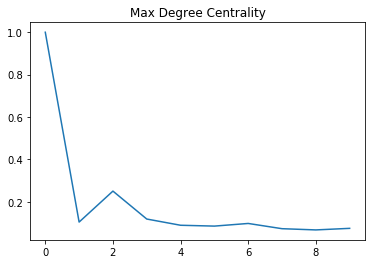

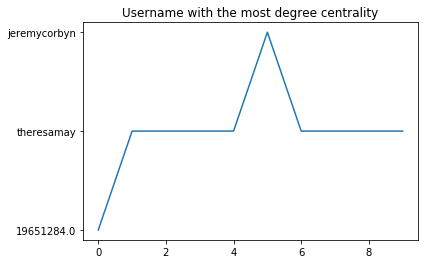

In [173]:
plt.plot(max_gc)
plt.title("Max Degree Centrality")
plt.show()
max_dc[1]="theresamay"
max_dc[4]="theresamay"
plt.title("Username with the most degree centrality")
plt.plot(max_dc)
plt.show()

In [47]:
import numpy as np
from scipy import stats
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns

print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")
degrees = [val for (node, val) in graph.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")

if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")

print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")
largest_subgraph = max(nx.connected_component_subgraphs(graph), key=len)
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest component of the Graph")
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")

print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = max(graph_centrality.items(), key=itemgetter(1))
print(max_de)
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = max(graph_closeness.items(), key=itemgetter(1))

graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)

max_bet = max(graph_betweenness.items(), key=itemgetter(1))
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

There are 294 nodes and 280 edges present in the Graph
The maximum degree of the Graph is 42
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 1.9
The most frequent degree of the nodes found in the Graph is 1
The graph is not connected
There are 40 connected components in the Graph
There are 186 nodes and 211 edges present in the largest component of the Graph
The graph is connected
The average clustering coefficient is 0.0 in the largest subgraph
The transitivity of the largest subgraph is 0
The diameter of our Graph is 14
The average distance between any two nodes is 4.93
('22196720', 0.22702702702702704)
the node with id 22196720 has a degree centrality of 0.23 which is the maximum of the Graph
the node with id 22196720 has a closeness centrality of 0.34 which is the maximum of the Graph
the node with id 22196720 has a betweenness centrality of 0.60 which is the maximum of the Graph


In [41]:
import pandas

dates_jeremycorbyn = []
# f is the file pointer to the JSON data set
for i in range(len(dfn)):
    user, interactions = get_interactions(dfn.loc[i,:])
    if "borisjohnson" in interactions:
        dates_jeremycorbyn.append(dfn.loc[i,"date"])
    
 
# a list of "1" to count the hashtags
ones = [1]*len(dates_jeremycorbyn)
# the index of the series
idx = pandas.DatetimeIndex(dates_jeremycorbyn)
# the actual series (at series of 1s for the moment)
jeremycorbyn = pandas.Series(ones, index=idx)
 
# Resampling / bucketing
per_3H = jeremycorbyn.resample('12H').sum().fillna(0)


-0.3094137842061186
0.044887984715092484
0.05193654429663618


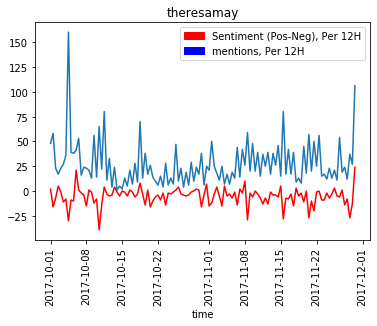

0.03094137842061186
0.004488798471509249
0.005193654429663618
0.014402374703221098
-0.11021605126783177
-0.17785951464862926


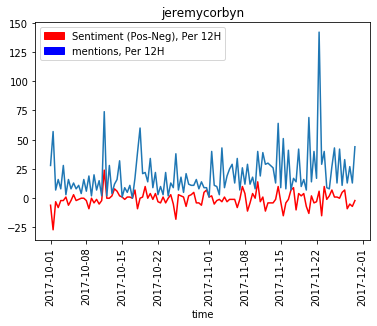

0.03238161589093397
0.015510403598292425
0.022979605894526543
-0.4340673610246007
-0.2206466126338843
-0.17602867429678837


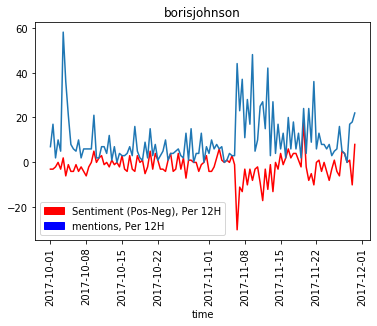

0.07578835199339404
0.03757506486168085
0.04058247332420538
0.020271842945085123
-0.03630168362919908
-0.01682158021960805


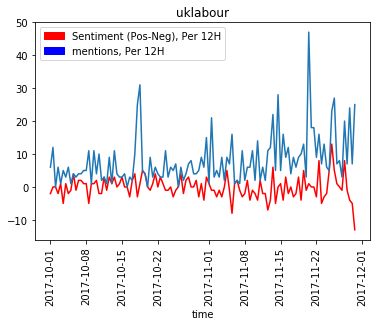

0.07781553628790255
0.041205233224600755
0.04226463134616619
-0.24069401623271247
-0.0390389921488445
-0.1824547359469954


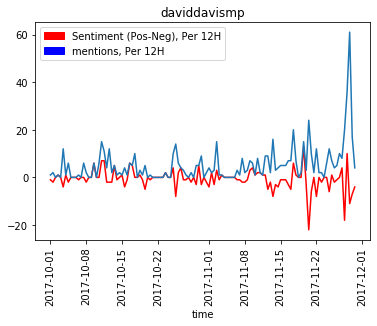

0.10188493791117378
0.04510913243948521
0.06051010494086573
-0.44706505999583795
-0.25327730319911196
-0.08966295441657501


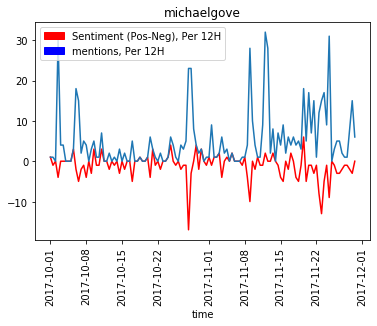

0.14659144391075757
0.0704368627593964
0.06947640038252323
0.26352306466445957
0.18571601611900743
0.02516416081929934


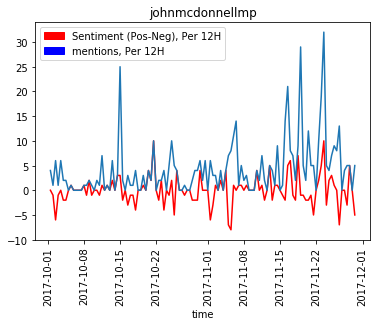

0.17294375037720353
0.08900846437129714
0.07199281646445317
-0.06660604662643846
-0.09148702853697405
-0.046126363055603754


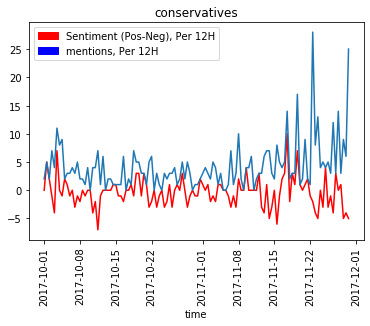

0.17960435503984737
0.09815716722499454
0.07660545277001354
-0.7101364250901365
-0.3482654234631669
-0.2978002966571155


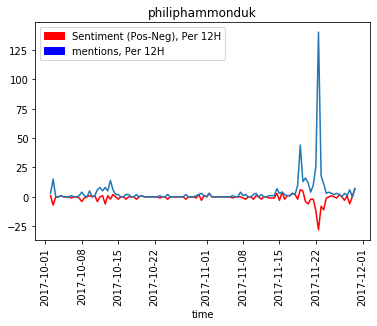

0.25061799754886105
0.13298370957131125
0.1063854824357251
-0.17209491648480413
0.0029235017269956293
0.11770746189130268


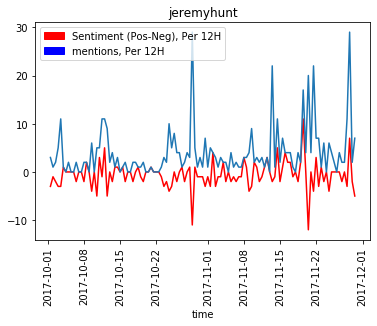

0.26782748919734145
0.13327605974401083
0.11815622862485538


In [164]:
a1 = 0
a2 = 0
a3 = 0
for mention in top_mentions_sorted:
    dates_jeremycorbyn = []
    pos_sent_jeremycorbyn = []
    neg_sent_jeremycorbyn = []
    # f is the file pointer to the JSON data set
    for i in range(len(dfn)):
        user, interactions = get_interactions(dfn.loc[i,:])
        if mention[0] in interactions:
            dates_jeremycorbyn.append(dfn.loc[i,"date"])
            if dfn.loc[i,"sentiment"] == "Positive":
                pos_sent_jeremycorbyn.append(dfn.loc[i,"date"])
            elif dfn.loc[i,"sentiment"] == "Negative":
                neg_sent_jeremycorbyn.append(dfn.loc[i,"date"])

    # a list of "1" to count the hashtags
    ones = [1]*len(dates_jeremycorbyn)
    pones = [1]*len(pos_sent_jeremycorbyn)
    nones = [-1]*len(neg_sent_jeremycorbyn)
    # the index of the series
    idx = pandas.DatetimeIndex(dates_jeremycorbyn)
    pidx = pandas.DatetimeIndex(pos_sent_jeremycorbyn) 
    nidx = pandas.DatetimeIndex(neg_sent_jeremycorbyn)
    # the actual series (at series of 1s for the moment)
    jeremycorbyn = pandas.Series(ones, index=idx)
    posco = pandas.Series(pones, index=pidx)
    nosco = pandas.Series(nones, index=nidx)
    sent = posco.append(nosco)
    # Resampling / bucketing
    per_3H = jeremycorbyn.resample('12H').sum().fillna(0)
    tryhard = sent.resample('12H').sum().fillna(0)
    print(tryhard.corr(per_3H))
    a1+=abs(tryhard.corr(per_3H))
    print(tryhard.shift(1).corr(per_3H))
    a2+=abs(tryhard.shift(1).corr(per_3H))
    print(tryhard.shift(-1).corr(per_3H))
    a3+=abs(tryhard.shift(-1).corr(per_3H))
    plt.plot(tryhard,c="red")
    #plt.show()
    #plt.ylabel(mention[0])
    plt.xlabel("time")
    plt.title(mention[0])
    plt.tick_params(axis='x', rotation=90)
    import matplotlib.patches as mpatches
    red_patch = mpatches.Patch(color='red', label='Sentiment (Pos-Neg), Per 12H')
    blue_patch = mpatches.Patch(color='blue', label='mentions, Per 12H')
    plt.legend(handles=[red_patch,blue_patch])
    plt.plot(per_3H)
    plt.show()
    print(a1/10)
    print(a2/10)
    print(a3/10)

-0.3094137842061186
0.044887984715092484
0.05193654429663618
0.03094137842061186
0.004488798471509249
0.005193654429663618
0.014402374703221098
-0.11021605126783177
-0.17785951464862926
0.03238161589093397
0.015510403598292425
0.022979605894526543
-0.4340673610246007
-0.2206466126338843
-0.17602867429678837
0.07578835199339404
0.03757506486168085
0.04058247332420538
0.020271842945085123
-0.03630168362919908
-0.01682158021960805
0.07781553628790255
0.041205233224600755
0.04226463134616619
-0.24069401623271247
-0.0390389921488445
-0.1824547359469954
0.10188493791117378
0.04510913243948521
0.06051010494086573
-0.44706505999583795
-0.25327730319911196
-0.08966295441657501
0.14659144391075757
0.0704368627593964
0.06947640038252323
0.26352306466445957
0.18571601611900743
0.02516416081929934
0.17294375037720353
0.08900846437129714
0.07199281646445317
-0.06660604662643846
-0.09148702853697405
-0.046126363055603754
0.17960435503984737
0.09815716722499454
0.07660545277001354
-0.7101364250901365


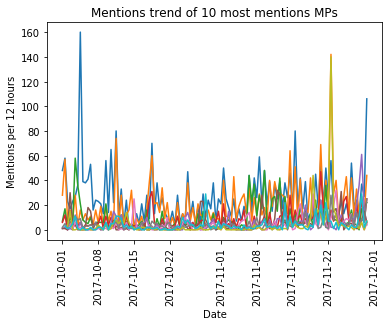

In [172]:
a1 = 0
a2 = 0
a3 = 0
for mention in top_mentions_sorted:
    dates_jeremycorbyn = []
    pos_sent_jeremycorbyn = []
    neg_sent_jeremycorbyn = []
    # f is the file pointer to the JSON data set
    for i in range(len(dfn)):
        user, interactions = get_interactions(dfn.loc[i,:])
        if mention[0] in interactions:
            dates_jeremycorbyn.append(dfn.loc[i,"date"])
            if dfn.loc[i,"sentiment"] == "Positive":
                pos_sent_jeremycorbyn.append(dfn.loc[i,"date"])
            elif dfn.loc[i,"sentiment"] == "Negative":
                neg_sent_jeremycorbyn.append(dfn.loc[i,"date"])

    # a list of "1" to count the hashtags
    ones = [1]*len(dates_jeremycorbyn)
    pones = [1]*len(pos_sent_jeremycorbyn)
    nones = [-1]*len(neg_sent_jeremycorbyn)
    # the index of the series
    idx = pandas.DatetimeIndex(dates_jeremycorbyn)
    pidx = pandas.DatetimeIndex(pos_sent_jeremycorbyn) 
    nidx = pandas.DatetimeIndex(neg_sent_jeremycorbyn)
    # the actual series (at series of 1s for the moment)
    jeremycorbyn = pandas.Series(ones, index=idx)
    posco = pandas.Series(pones, index=pidx)
    nosco = pandas.Series(nones, index=nidx)
    sent = posco.append(nosco)
    # Resampling / bucketing
    per_3H = jeremycorbyn.resample('12H').sum().fillna(0)
    tryhard = sent.resample('12H').sum().fillna(0)
    print(tryhard.corr(per_3H))
    a1+=abs(tryhard.corr(per_3H))
    print(tryhard.shift(1).corr(per_3H))
    a2+=abs(tryhard.shift(1).corr(per_3H))
    print(tryhard.shift(-1).corr(per_3H))
    a3+=abs(tryhard.shift(-1).corr(per_3H))
    #plt.plot(tryhard,c="red")
    
    plt.ylabel("Mentions per 12 hours")
    plt.xlabel("Date")
    plt.title("Mentions trend of 10 most mentions MPs")
    plt.tick_params(axis='x', rotation=90)
    import matplotlib.patches as mpatches
    
    plt.plot(per_3H)
    #plt.show()
    print(a1/10)
    print(a2/10)
    print(a3/10)
plt.show()

-0.17209491648480413
0.0029235017269956293


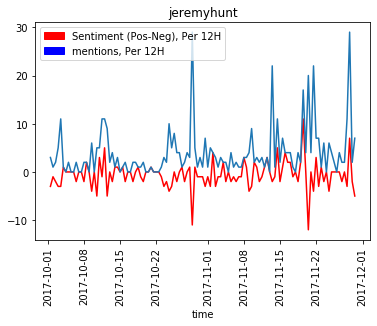

In [159]:
for i in range(1):
    print(tryhard.corr(per_3H))
    print(tryhard.shift(1).corr(per_3H))
    plt.plot(tryhard,c="red")
    #plt.show()
    #plt.ylabel(mention[0])
    plt.xlabel("time")
    plt.title(mention[0])
    plt.tick_params(axis='x', rotation=90)
    import matplotlib.patches as mpatches
    red_patch = mpatches.Patch(color='red', label='Sentiment (Pos-Neg), Per 12H')
    blue_patch = mpatches.Patch(color='blue', label='mentions, Per 12H')
    plt.legend(handles=[red_patch,blue_patch])
    plt.plot(per_3H)
    plt.show()